# Hateful Memes

### Hosted BY FACEBOOK

Your goal is to create an algorithm that identifies multimodal hate speech in internet memes.

Take an image, add some text: you've got a meme. Internet memes are often harmless and sometimes hilarious. However, by using certain types of images, text, or combinations of each of these data modalities, the seemingly non-hateful meme becomes a multimodal type of hate speech, a hateful meme.

At the massive scale of the internet, the task of detecting multimodal hate is both extremely important and particularly difficult. As the illustrative memes above show, relying on just text or just images to determine whether or not a meme is hateful is insufficient.
Link: https://www.drivendata.org/competitions/64/hateful-memes/

On this notebook, we will use both NLP & image classifcation for classify harmfull Memes.
Memes, could be either: insult text over a valid image or a valid text on harmful image.

## Part:1 - NLP Classification
In this part, we are going to do some NLP work to find inappropriate or insult words.

## Part:2 - Image Classification
In this part, we run an deep learning for for detect an harmful image.

## Part:3 - Put All Together
On the final part, we need to combine both NLP calssification & image calssification for answer the question:
Which Meme is valid and which of then is harmful.

## Part:1 - NLP Classification

In [ ]:
#Setp:1 - Libraries
import json
import pandas as pd
from nltk.tokenize import sent_tokenize
import nltk
en_stop = set(nltk.corpus.stopwords.words('english'))
from nltk.stem import WordNetLemmatizer
import os
import re
import cv2
import numpy as np
import fastai
import shutil

In [ ]:
#Step:2 - Load JSON train set as Dataframe
#Load train json into pandas
trainDF = pd.read_json('G:/DataScienceProject/HatefulMemes/data/train.jsonl', lines=True)
trainDF['id'] = trainDF['id'].astype('int32')
trainDF['label'] = trainDF['label'].astype('int32')
trainDF.head()

In [ ]:
#Step:3 - Load dev(CV) & test json into pandas
#Dev 
devDF = pd.read_json('G:/DataScienceProject/HatefulMemes/data/dev.jsonl', lines=True)
devDF['id'] = devDF['id'].astype('int32')
devDF['label'] = devDF['label'].astype('int32')

#Test
testDF = pd.read_json('G:/DataScienceProject/HatefulMemes/data/test.jsonl', lines=True)
testDF['id'] = testDF['id'].astype('int32')
testDF['label'] = 0
testDF['label'] = testDF['label'].astype('int32')
testDF.head()

In [ ]:
#Step:4 - Clean text
stemmer = WordNetLemmatizer()
#Preprocess func
def preprocess_text(document):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(document))
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    # Converting to Lowercase
    document = document.lower()
    # Lemmatization
    tokens = document.split()
    tokens = [stemmer.lemmatize(word) for word in tokens]
    tokens = [word for word in tokens if word not in en_stop]
    tokens = [word for word in tokens if len(word) > 3]
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

#TEXT need STR
trainDF['textNew'] = ''
for i, value in enumerate(trainDF['text']):
    text = sent_tokenize(str(value))
    trainDF['textNew'].loc[i] = preprocess_text(text)

devDF['textNew'] = ''
for i, value in enumerate(devDF['text']):
    text = sent_tokenize(str(value))
    devDF['textNew'].loc[i] = preprocess_text(text)

testDF['textNew'] = ''
for i, value in enumerate(testDF['text']):
    text = sent_tokenize(str(value))
    testDF['textNew'].loc[i] = preprocess_text(text)

In [ ]:
#Step:5 - Check word profanity & count profanity
trainDF['profanity'] = 0
trainDF['profanity'] = trainDF['profanity'].astype('int32')
devDF['profanity'] = 0
devDF['profanity'] = devDF['profanity'].astype('int32')
testDF['profanity'] = 0
testDF['profanity'] = testDF['profanity'].astype('int32')

#Load Google profanity dictionary
profanityPath = 'G:/DataScienceProject/HatefulMemes/Google-profanity.txt'
with open(profanityPath, 'r') as f:
    profanity = f.read()
    f.close()

profanity = profanity.split("\n")

#Need to split text into list per a row
for i, value in enumerate(trainDF['textNew']):
    rowText = trainDF['textNew'].loc[i].split(" ")
    if set(profanity).intersection(list(set(rowText))) != 0:
        trainDF['profanity'].loc[i] = len(set(profanity).intersection(list(set(rowText))))

for i, value in enumerate(devDF['textNew']):
    rowText = devDF['textNew'].loc[i].split(" ")
    if set(profanity).intersection(list(set(rowText))) != 0:
        devDF['profanity'].loc[i] = len(set(profanity).intersection(list(set(rowText))))

for i, value in enumerate(testDF['textNew']):
    rowText = testDF['textNew'].loc[i].split(" ")
    if set(profanity).intersection(list(set(rowText))) != 0:
        testDF['profanity'].loc[i] = len(set(profanity).intersection(list(set(rowText))))

#Let;s check if we got a profanity issue:
print("Profanity %: {:2f}".format((sum(trainDF['profanity'])/len(trainDF['text']))*100))

In [ ]:
#Step:6 - Reorder col & save
trainDF = trainDF.drop(['text', 'textNew'], axis=1)
devDF = devDF.drop(['text', 'textNew'], axis=1)
testDF = testDF.drop(['text', 'textNew'], axis=1)
colList = list(trainDF.columns)
colList.remove('label')
colList.append('label')
#colList
trainDF = trainDF[colList]
devDF = devDF[colList]
testDF = testDF[colList]
trainDF.to_csv('G:/DataScienceProject/HatefulMemes/trainDF_prof.csv', index=False)
devDF.to_csv('G:/DataScienceProject/HatefulMemes/devDF_prof.csv', index=False)
testDF.to_csv('G:/DataScienceProject/HatefulMemes/testDF_prof.csv', index=False)

As for now, we are able to classify Memes text.
Let's continue with image classification.

## Part:2 - Image Classification

In [ ]:
#Step:7 - Image resize
def imgResize(file):
    fullImgName = folder + file
    img = cv2.imread(fullImgName)
    width = img.shape[1]
    height = img.shape[0]

    if width > height:
        ratio = int(width / 224)
        if ratio > 1:
            width = 224
            height = int(height / ratio)
        else:
            width = 224
            height = 224

    elif height > width:
        ratio = int(height / 224)
        if ratio > 1:
            height = 224
            width = int(width / ratio)
        else:
            width = 224
            height = 224

    elif width == height:
        width = 224
        height = 224

    # dsize
    dsize = (width, height)

    # resize image
    output = cv2.resize(img, dsize)
    cv2.imwrite(fullImgName, output)

    return

for i, value in enumerate(imgList):
    imgResize(value)


In [ ]:
#Step:8- Create folder & split train
#Create train, cv(dev), test folders
if os.path.exists('G:/DataScienceProject/HatefulMemes/train') is not None:
    os.mkdir('G:/DataScienceProject/HatefulMemes/train')
    os.mkdir('G:/DataScienceProject/HatefulMemes/train/harmful')
    os.mkdir('G:/DataScienceProject/HatefulMemes/train/non-harmful')

if os.path.exists('G:/DataScienceProject/HatefulMemes/cv') is not None:
    os.mkdir('G:/DataScienceProject/HatefulMemes/cv')
    os.mkdir('G:/DataScienceProject/HatefulMemes/cv/harmful')
    os.mkdir('G:/DataScienceProject/HatefulMemes/cv/non-harmful')

if os.path.exists('G:/DataScienceProject/HatefulMemes/test') is not None:
    os.mkdir('G:/DataScienceProject/HatefulMemes/test')

#Split image according to their labels:
folder = 'G:/DataScienceProject/HatefulMemes/data/img/'
trainDF = pd.read_csv("G:/DataScienceProject/HatefulMemes/trainDF_prof.csv")
for i, value in enumerate(trainDF['id']):
    #print(str(value) + '.png')
    if len(str(trainDF['id'][i])) == 5:
        imgSrc = folder + str(value) + '.png'
    else:
        imgSrc = folder + '0' + str(value) + '.png'
    if trainDF['label'][i] == 1:
        imgDst = 'G:/DataScienceProject/HatefulMemes/train/harmful/' + str(value) + '.png'
    else:
        imgDst = 'G:/DataScienceProject/HatefulMemes/train/non-harmful/' + str(value) + '.png'

    shutil.copyfile(imgSrc, imgDst)

devDF = pd.read_csv("G:/DataScienceProject/HatefulMemes/devDF_prof.csv")
for i, value in enumerate(devDF['id']):
    #As image id once dispalyed as str while other dispalyed as int
    #Means that img id: 01224 can be dispalyed 1234 - we nedd to add 0
    if len(str(devDF['id'][i])) == 5:
        imgSrc = folder + str(value) + '.png'
    else:
        imgSrc = folder + '0' + str(value) + '.png'
    if devDF['label'][i] == 1:
        imgDst = 'G:/DataScienceProject/HatefulMemes/cv/harmful/' + str(value) + '.png'
    else:
        imgDst = 'G:/DataScienceProject/HatefulMemes/cv/non-harmful/' + str(value) + '.png'

    shutil.copyfile(imgSrc, imgDst)

testDF = pd.read_csv("G:/DataScienceProject/HatefulMemes/testDF_prof.csv")
for i, value in enumerate(testDF['id']):
    #print(str(value) + '.png')
    if len(str(testDF['id'][i])) == 5:
        imgSrc = folder + str(value) + '.png'
    else:
        imgSrc = folder + '0' + str(value) + '.png'
    imgDst = 'G:/DataScienceProject/HatefulMemes/test/' + str(value) + '.png'
    shutil.copyfile(imgSrc, imgDst)

In [1]:
#Step:9- FASTAI
from fastai.vision import *
import warnings
warnings.filterwarnings('ignore')
path = 'G:/DataScienceProject/HatefulMemes/train'
folderList = os.listdir(path)
data = ImageDataBunch.from_folder(path,
                                  train=".",
                                  test="../cv",
                                  valid_pct=0.2,
                                  classes=folderList)

In [2]:
#Step:10 - Check accuricy over iteration 
from fastai.metrics import error_rate # 1 - accuracy
learn = create_cnn(data, models.resnet34, metrics=accuracy)
defaults.device = torch.device('cuda') # makes sure the gpu is used
learn.fit_one_cycle(15)

epoch,train_loss,valid_loss,accuracy,time
0,1.128977,0.751048,0.599412,01:55
1,0.934994,0.768768,0.619412,00:58
2,0.741383,0.669122,0.628235,00:55
3,0.675674,0.662907,0.621765,00:55
4,0.654934,0.689120,0.621176,00:55
5,0.639400,0.679731,0.621765,00:56
6,0.607651,0.679025,0.628235,00:57
7,0.582655,0.714491,0.622941,00:56
8,0.544849,0.695222,0.637647,00:59
9,0.500382,0.712179,0.634706,01:04


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


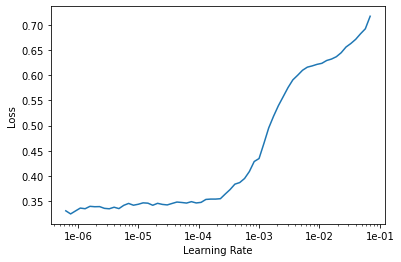

In [3]:
learn.unfreeze() # must be done before calling lr_find
learn.lr_find()
learn.recorder.plot()

In [4]:
learn.fit_one_cycle(15, max_lr=slice(3e-5, 3e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.370912,0.781442,0.627059,01:09
1,0.334173,0.813298,0.617647,01:09
2,0.322590,0.927165,0.620000,01:08
3,0.304326,0.962594,0.635882,01:08
4,0.242204,1.046814,0.650000,01:07
5,0.180188,1.101047,0.629412,01:07
6,0.137428,1.236673,0.610588,01:08
7,0.091184,1.323357,0.647647,01:07
8,0.065771,1.314638,0.640588,01:07
9,0.041713,1.422832,0.642941,01:10


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


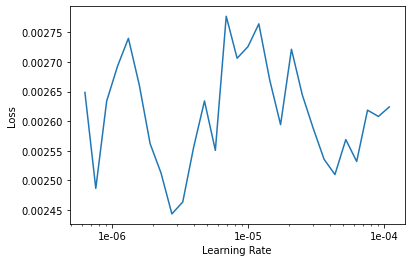

In [5]:
learn.unfreeze() # must be done before calling lr_find
learn.lr_find()
learn.recorder.plot()

In [6]:
#Step:11 - Final model & save
if os.path.exists('G:/DataScienceProject/webcrawler/train/models/tmp.pth'):
    os.remove('G:/DataScienceProject/webcrawler/train/models/tmp.pth')
    os.rmdir('G:/DataScienceProject/webcrawler/train/models')
else:
    {}

learn.fit_one_cycle(15, max_lr=slice(3e-5, 3e-4))
learn.export('G:/DataScienceProject/HatefulMemes/fastai.pkl')

epoch,train_loss,valid_loss,accuracy,time
0,0.004419,1.592780,0.638824,01:09
1,0.006852,1.776606,0.648823,01:08
2,0.057547,1.897591,0.592941,01:07
3,0.108457,1.822715,0.643529,01:07
4,0.102978,1.585258,0.608824,01:07
5,0.093831,1.677260,0.596471,01:07
6,0.068257,1.621009,0.634706,01:07
7,0.048783,1.671408,0.621176,01:07
8,0.032073,1.757552,0.636471,01:07
9,0.024467,1.739254,0.620588,01:08


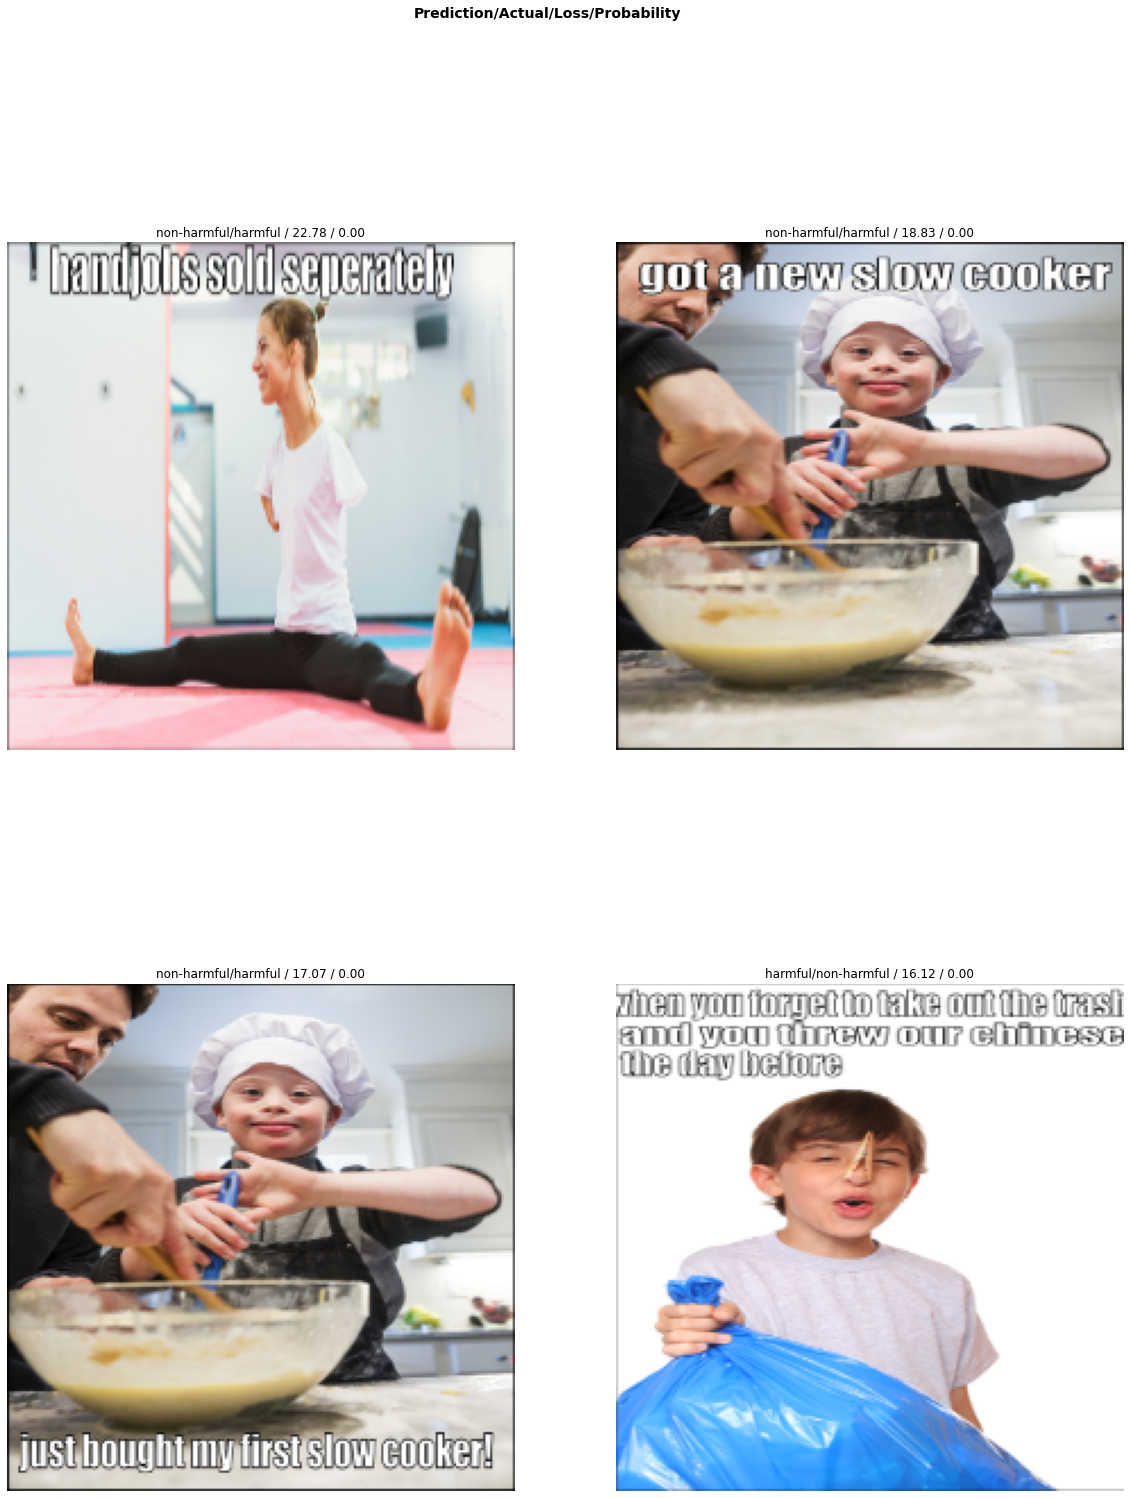

In [7]:
#Step12 - Image class interpetation
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(4, figsize=(20,25))

In [66]:
#Step13 - Image classification
import fastai
from fastai.metrics import error_rate
from fastai.vision import *
import warnings
import pandas as pd
import os

learn = load_learner('G:/DataScienceProject/HatefulMemes/', 'fastai.pkl')

devDF = pd.read_csv('G:/DataScienceProject/HatefulMemes/devDF_prof.csv')
testDF = pd.read_csv('G:/DataScienceProject/HatefulMemes/testDF_prof.csv')
devDF['imgClass'] = 0
testDF['imgClass'] = 0
devDF['id'] = devDF['id'].astype('int32')
testDF['id'] = testDF['id'].astype('int32')

cvPath = 'G:/DataScienceProject/HatefulMemes/data/img/'
for i in range(0, len(devDF)):
    if devDF['id'].loc[i] < 10000:
        file = cvPath + '0' + str(devDF['id'].loc[i]) + '.png'
    else:
        file = cvPath + str(devDF['id'].loc[i]) + '.png'
    img = open_image(file)
    pred_class, pred_idx, output = learn.predict(img)
    if str(pred_class) == 'harmful':
        devDF['imgClass'].loc[i] == 1



testPath = cvPath
for i in range(0, len(testDF)):
    if testDF['id'].loc[i] < 10000:
        file = cvPath + '0' + str(testDF['id'].loc[i]) + '.png'
    else:
        file = cvPath + str(testDF['id'].loc[i]) + '.png'
    img = open_image(file)
    pred_class, pred_idx, output = learn.predict(img)
    if str(pred_class) == 'harmful':
        testDF['imgClass'].loc[i] == 1

devDF = devDF.drop(['img'], axis=1)
testDF = testDF.drop(['img'], axis=1)

colList = list(devDF.columns)
colList.remove('label')
colList.append('label')
devDF = devDF[colList]

colList = list(testDF.columns)
colList.remove('label')
colList.append('label')
testDF = testDF[colList]

devDF.to_csv('G:/DataScienceProject/HatefulMemes/devDF_forPhase2.csv', index=False)
testDF.to_csv('G:/DataScienceProject/HatefulMemes/testDF_forPhase2.csv', index=False)
'''
id,proba,label
39420,0.4,0
'''

'\nid,proba,label\n39420,0.4,0\n'

# Part:3 - Put All Together

Now we can run the overlay ML agorithm.
We got the profanity check as count of harmful words.
Also, we have the image classification.
The above will give us 2 new classification features
So, what keeping us from run the final do the final ML?

In [8]:
#Step14 - Build the final ML that overlay on both NLP & image classification
import nbconvert
import pandas as pd
from pycaret.classification import *

devDF = pd.read_csv('G:/DataScienceProject/HatefulMemes/devDF_forPhase2.csv')
testDF = pd.read_csv('G:/DataScienceProject/HatefulMemes/testDF_forPhase2.csv')
exp1 = setup(devDF, target = 'label')

 
Setup Succesfully Completed!


,Description,Value
0,session_id,4952
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(500, 4)"
4,Missing Values,False
5,Numeric Features,1
6,Categorical Features,2
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [9]:
#Step:15 - Compare modules
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Light Gradient Boosting Machine,0.561600,0.572000,0.596700,0.557700,0.573600,0.124800
1,Random Forest Classifier,0.558600,0.565900,0.497100,0.574400,0.531000,0.117600
2,Gradient Boosting Classifier,0.549900,0.526300,0.515000,0.552500,0.529500,0.100700
3,Decision Tree Classifier,0.547100,0.547400,0.503300,0.557000,0.524900,0.094800
4,Extra Trees Classifier,0.544200,0.536100,0.502900,0.552800,0.525400,0.088800
5,CatBoost Classifier,0.544100,0.553800,0.532000,0.551000,0.537100,0.089100
6,Ada Boost Classifier,0.532900,0.531300,0.476100,0.545800,0.495800,0.067800
7,Naive Bayes,0.527200,0.530300,0.396100,0.541400,0.450500,0.057600
8,Extreme Gradient Boosting,0.521300,0.528300,0.521600,0.525100,0.515500,0.044800
9,Logistic Regression,0.498600,0.540700,0.000000,0.000000,0.000000,0.000000


This above comparison, give us very low accuracy.
So, let's stack few MLs into a single model.

In [10]:
#Step:16 - Stacking model for improve ML
ridge = create_model('ridge')
lda = create_model('lda')
gbc = create_model('gbc')
xgboost = create_model('xgboost')

# stacking models
stacker = stack_models(estimator_list = [ridge,lda,gbc], meta_model = xgboost)

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.5429,0.5621,0.5556,0.5556,0.5556,0.0850
1,0.4857,0.5245,0.2778,0.5000,0.3571,-0.0161
2,0.6571,0.7435,0.5556,0.7143,0.6250,0.3182
3,0.6857,0.6732,0.7778,0.6667,0.7179,0.3678
4,0.5714,0.5882,0.6111,0.5789,0.5946,0.1408
5,0.5714,0.6111,0.4706,0.5714,0.5161,0.1379
6,0.7714,0.7582,0.7647,0.7647,0.7647,0.5425
7,0.7714,0.8088,0.8235,0.7368,0.7778,0.5440
8,0.6857,0.7761,0.5294,0.7500,0.6207,0.3657
9,0.6176,0.5865,0.5294,0.6429,0.5806,0.2353


In [14]:
save_experiment(experiment_name = 'G:/DataScienceProject/HatefulMemes/Exp1')

Experiment Succesfully Saved


In [15]:
#Step17 - Prediction
prediction = predict_model(stacker, data = testDF)

In [18]:
print(prediction)

        id  profanity  imgClass  label  Label   Score
0    16395          0         0      0      1  0.9847
1    37405          0         0      0      1  0.9847
2    94180          0         0      0      1  0.9847
3    54321          0         0      0      1  0.9847
4    97015          0         0      0      1  0.9847
..     ...        ...       ...    ...    ...     ...
995   3869          0         0      0      1  0.9847
996  23817          0         0      0      1  0.9847
997  56280          0         0      0      1  0.9847
998  29384          0         0      0      1  0.9847
999  34127          0         0      0      1  0.9847

[1000 rows x 6 columns]


In [19]:
#Step18 - Submission
submission = pd.DataFrame(columns=['id', 'proba', 'label'])
submission['id'] = prediction['id']
submission['proba'] = prediction['Score']
submission['label'] = prediction['Label']
submission.to_csv("G:/DataScienceProject/HatefulMemes/submit1.csv", index=False)